# TP3: Model Free

### Descripción del código: 

En este Trabajo se les presenta un juego de mesa (una versión simplificada del Perudo: https://www.youtube.com/watch?v=die0n-eonl8, juego que aparece en la pelicula Piratas Del Caribe 2: El cofre de la Muerte). A partir de las reglas de dicho juego se construye un environment.

Además se les brinda un breve código en donde se juega contra dicho environment de forma aleatoria.

Por ultimo, también encontraran dos funciones para graficar la Value function y una política respectivamente.

### Consignas:

1. Implementar el método de Monte Carlo, SARSA y Q-learning para aprender la función valor.

 Nota: no es necesario, pero si recomendable, usar el esqueleto de funciones que aparecen abajo.
 

2. Para cada uno de los 3 casos, graficar dicha función valor y la política optima encontrada.


3. Crear un nuevo environment que tome como parámetro una política (dicho parámetro deberá ser la política realizada por la IA).

 Luego realizar iteraciones para cualquiera de los 3 métodos mencionados, en donde para cada iteración encuentre una política óptima para un jugador que se enfrenta contra la política óptima del paso anterior.

 Nuevamente graficar la función valor y la política optima final.

In [ ]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://i.ytimg.com/vi/gMGsAxuWozQ/maxresdefault.jpg")

In [442]:
import gym
import numpy as np
import random
from gym import spaces
from gym.utils import seeding
import pprint

## El juego

Reglas:

- 2 jugadores (uno sos vos y una IA)
- Cada jugador cuenta con **5 monedas** (cara o cruz). Cada jugador solo ve sus monedas. 
- Después de tirar las monedas, empieza el juego.
- El juego consiste en intentar adivinar al menos **cuantas caras hay en total** entre todas las monedas o en hacer que el **rival adivine incorrectamente**.
- La apuesta empieza en 0 caras.
- Se tira una moneda para ver quien de los dos jugadores empieza. 
- Acciones posibles:
    * me quedo con la apuesta hasta ahora y paso.
    * subo en 1 la cantidad de caras que creo que hay en total.
- El juego termina cuando algún jugador pasa.
- Si la apuesta fue **mayor** al numero real de caras, **el apostador pierde** (r=-1) y el otro gana.
- Si la apuesta es **menor o igual** al numero real, **gana el apostador** (r=1) y pierde el otro.
- IA inicial de la computadora: Si la apuesta es menor a 2 + cantidad de caras propias, la computadora apuesta. Sino pasa.

In [ ]:
# Defino nuestro propio environment con las reglas del juego

def throw_coin(num_coin, np_random):
    return np_random.rand(num_coin)>0.5

def total_faces(list_players):
    RV=0
    for player in list_players:
        RV += sum(player)
    return RV

class PerudoSimplificado(gym.Env):
    def __init__(self):
        
        self.action_space = spaces.Discrete(2)
        self.observation_space = spaces.Tuple((
            spaces.Discrete(5), #mis monedas
            spaces.Discrete(10))) #apuesta actual

        self.seed()
        # Empieza el juego
        self.reset()

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action):
        assert self.action_space.contains(action)
        
        max_guess_player_2 = total_faces([self.player_2]) + int(len(self.player_1)/2)
        faces_tot = total_faces([self.player_1, self.player_2])
        
        if self.guess > len(self.player_1) + len(self.player_2): #la apuesta es mayor que lo maximo posible
            done = True
            reward = -1

        if action == 0: #action == 0, mantengo la apuesta y paso
            done = True
            if self.guess <= faces_tot: #tenia razon el rival
                reward = -1
            else: #tenia razon yo
                reward = +1
            
        else: #action == 1, subo en 1 la apuesta
            self.guess += 1
            if self.guess < max_guess_player_2: #el rival sube 1 en su turno
                self.guess += 1 
                done = False
                reward = 0
            else: # el rival pasa
                done = True
                if self.guess <= faces_tot: 
                    reward = 1
                else:
                    reward = -1
            
        return self.get_obs(), reward, done, {}

    def get_obs(self):
        return (sum(self.player_1), self.guess)
    
    def reset(self):
        self.player_1 = throw_coin(5,self.np_random)
        self.player_2 = throw_coin(5,self.np_random)
        self.guess = 1 if np.random.rand()>0.5 else 0 #al principio se tira una moneda para ver quien empieza. Por eso es 0 (uno empieza) o 1 (empezo el otro y subio)  
        return self.get_obs()

## Jugando al azar

In [ ]:
env = PerudoSimplificado()
print(env.observation_space)
print(env.action_space)

In [ ]:
#Politica Random:
for i_episode in range(1):
    state = env.reset()
    print("Starting at state:", state)
    while True:
        #action = env.action_space.sample() # Selecciona una accion random dentro de las posibles
        action = 1
        state, reward, done, info = env.step(action) # Juega un paso
        print(state, action)
        if done:
            print('El juego ha terminado! Su reward: ', reward)
            print('Ganaste :)\n') if reward > 0 else print('Perdiste :(\n')
            break

## Graficos:

In [354]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_values(V):
    """
    Realiza un grafico en 3 dimensiones de la función valor.
        
    El parametro V es un diccionario cuyas keys son pares "caras en mi mano" 
    y "apuesta actual".
    """
    def get_Z(x, y):
        if (x,y) in V:
            return V[x,y]
        else:
            return 0

    def get_figure(ax):
        x_range = np.arange(0, 6)
        y_range = np.arange(1, 11)
        X, Y = np.meshgrid(x_range, y_range)
        
        Z = np.array([get_Z(x,y) for x,y in zip(np.ravel(X), np.ravel(Y))]).reshape(X.shape)
        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=plt.cm.coolwarm, vmin=-1.0, vmax=1.0)
        ax.set_xlabel('caras en tu mano')
        ax.set_ylabel('apuestas')
        ax.set_zlabel('value')
        ax.view_init(ax.elev, -120)
    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(211, projection='3d')
    get_figure(ax)
    plt.show()

In [369]:
def plot_policy(policy):
    """
    Realiza un grafico en 3 dimensiones de la función valor.
    
    El parametro policy es un diccionario cuyas keys son pares "caras en mi mano" 
    y "apuesta actual" y el valor es la acción a realizar.
    """
    def get_Z(x, y):
        if (x,y) in policy:
            #return policy[x,y]
            return randomArgmax(policy[x,y])
        else:
            return 25 # este valor "25" es para visualizar que la policy no tiene asignada una acción para dicho estado.

    def get_figure(ax):
        x_range = np.arange(0, 6)
        y_range = np.arange(0, 11)
        X, Y = np.meshgrid(x_range, y_range)
        Z = np.array([[get_Z(x,y) for x in x_range] for y in y_range])
        
        print("X",X.shape)
        print("Y",Y.shape)
        print("Z",Z.shape)
        
        surf = ax.imshow(np.flip(Z,0), cmap=plt.get_cmap('Pastel2', 3), vmin=0, vmax=2, extent=[-0.5, 5.5, -0.5, 10.5])
        plt.xticks(x_range)
        plt.yticks(y_range)
        plt.gca().invert_yaxis()
        ax.set_xlabel('caras en mi mano')
        ax.set_ylabel('apuestas')
        ax.grid(color='w', linestyle='-', linewidth=1)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1)
        cbar = plt.colorbar(surf, ticks=[0,1,2], cax=cax)
        cbar.ax.set_yticklabels(['0 (pasar)','1 (subir)', 'desconocido'])
        print(Z)
            
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111)
    get_figure(ax)
    plt.show()

## Monte Carlo

In [871]:
# Filling these ones was freaking fun!

def get_probs(Q_s, epsilon, nA): 
    # Completar
    # Devuelve un array con las probs de cada accion, para un estado dado
    # policy:   {(s,s): (r_a1, r_a2)}
    # policy_s: [r_a1, r_a2]
    policy_s = np.zeros(nA)
    A_star = randomArgmax(Q_s)
    actions = np.arange(nA)
    for a in actions:
        if a == A_star:
            policy_s[a] = 1-epsilon + epsilon/nA
        else:
            policy_s[a] = epsilon/nA
    
#     if np.random.choice([1,0], p=[1-epsilon, epsilon]):
#         # Returning policy from Q
#         policy_s = Q_s
#     else:
#         # Returning random policy
#         policy_s = np.ones(len(Q_s))/nA
    #print("policy_s", policy_s, "eps:", epsilon, "eps/nA:",epsilon/nA)
    return policy_s
  
def generate_episode_from_Q(env, Q, epsilon, nA):
    # Completar
    #episode = {(s, s):[action k taken, inmediate reward_ak]}
    verbose = False
    episode = {}
    state = env.reset()
    actions = np.arange(nA)
    while True:
        
        action = np.random.choice(actions, p=get_probs(Q[state], epsilon, nA))
        state, reward, done, info = env.step(action) # Juega un paso
#         print("get_probs(Q[state], epsilon, nA):", get_probs(Q[state], epsilon, nA),
#                       "\tQ[state]:", Q[state], "\t  action:",action, "reward:", reward)
        
        if state not in episode:
            # First Visit MC.
            #actions_reward = np.zeros(nA)
            #actions_reward[action] = reward
            #episode[state] = np.insert(actions_reward, action, reward)
            #episode[state] = actions_reward
            episode[state] = [action, reward]
            #print("New epi:", episode[state], "-", episode)
        if done:
            #print('El juego ha terminado! Su reward: ', reward)
            #print('Ganaste :)') if reward > 0 else print('Perdiste :(')
            break
    return episode

#def update_Q(env, episode, Q, alpha, gamma):
def update_Q(env, episode, Q, alpha, gamma, Returns, NumReturns):
    # Completar
    nA=2
    #TODO: ver si se puede hacer sin ese parametro Returns
    # Mete en returns los valores de episode
    #{ k: Returns.get(k, 0) + Q.get(k, 0) for k in set(Returns) | set(Q) }
    #
    #print(Returns)
    use_cumulative_average = True # faster results, and memory don't blow up with number of episodes
    for state in episode:
        # Adding episode first values to list of past Returns
        #print("before append: episode[state]", episode[state], "- Returns[state]", Returns[state])
        #for action,_ in enumerate(Returns[state]):
        if not use_cumulative_average:
            #Returns[state][idx] = np.append(Returns[state][idx], episode[state][idx])
            Returns[state][action].append(episode[state][action])
        else:
            #NumReturns[state] : [[0, 0], [0, 0]]
            action_taken  = episode[state][0]
            action_reward = episode[state][1]
            action_mean   = NumReturns[state][action_taken][0]
            action_count  = NumReturns[state][action_taken][1]
            
#             print("\naction_mean:", action_mean)
#             print("action_count:", action_count)
#             print("action_taken:", action_taken)
#             print("action_reward:", action_reward)
#             print("\nNumReturns[state] bef:", NumReturns[state])
#             print("NumReturns[state][action_taken]:",NumReturns[state][action_taken])
#             print("NumReturns[state][action_taken][0]:",NumReturns[state][action_taken][0])
#             print("NumReturns[state][action_taken][1]:",NumReturns[state][action_taken][1])
            
#             NumReturns[state][action_taken][0] = (action_mean * action_count + action_reward)/(action_count+1)
#             NumReturns[state][action_taken][1] += 1
            new_mean = (action_mean * action_count + action_reward)/(action_count+1)
            updated_returns = [new_mean, action_count+1]
            NumReturns[state][action_taken] = updated_returns
            
#             print("NumReturns[state] aft:",NumReturns[state])
        
#         for action in range(nA):
#             if not use_cumulative_average:
#                 #Returns[state][idx] = np.append(Returns[state][idx], episode[state][idx])
#                 Returns[state][action].append(episode[state][action])
#             else:
#                 # TODO
#                 # En vez de append, puedo usar el promedio step by step con la cant de veces conocida
#                 #NumReturns[state][action] : [mean, action count]
#                 action_mean = NumReturns[state][action][0]
#                 action_count= NumReturns[state][action][1]
#                 NumReturns[state][action][0] = (action_mean * action_count + episode[state][action])/(action_count+1)
#                 NumReturns[state][action][1] += 1
        #print("after  append: episode[state]", episode[state], "- Returns[state]", Returns[state])
        # Now Q(s,a) takes the mean of Returns(s,a);
        # axis=1 to take mean separately by action
        if not use_cumulative_average:
            Q[state] = np.mean(Returns[state], axis=1)
        else:
#             print("Q[state] before/after:")
#             pprint.pprint(Q[state])
            Q[state] = np.take(NumReturns[state], [0,2]) #[0,2] indexes of action mean returns
#             pprint.pprint(NumReturns[state])
#             pprint.pprint(Q[state])
        #print("episode[state]", episode[state], "- Q[state]", Q[state], "- Returns[state]", Returns[state])
    #print("Returns: ",Returns)
    #print("Q: ", Q)
    
    return Q

In [872]:
np.take(([2.5, 2],[1, 4]), [0,2])

array([2.5, 1. ])

<img src="./img/on-policy-first-visit-mc-control.png" width="500" align="left" />

In [873]:
D = {'a':1, 'b':2, 'c':3}
D

{'a': 1, 'b': 2, 'c': 3}

In [874]:
print(env.observation_space)
print(env.action_space)

Tuple(Discrete(5), Discrete(10))
Discrete(2)


In [875]:
([],)*3

([], [], [])

In [876]:
def randomArgmax(v):
    """Like np.argmax(), but if there are several "best" actions,
       chooses and returns one randomly"""
    arguments = np.argwhere(v == np.amax(v)).ravel()
    arg = np.random.choice(arguments)
    return arg

def softmax_vect(v):
    """Returns a vector with all softmax values"""
    exp_vect = np.exp(v)
    return exp_vect/np.sum(exp_vect)

In [877]:
def initialize_QPol_est(D, default_value, nA):
    # states: (c, a) 
    #           for all c in [0,5]
    #           for all a in [0,10]
    # actions: (v0, v1) < (0.5, 0.5)
    # Q = {(c,a):(v0,v1),...,(d,b):(v0,v1)}
    #armo todos los posibles indices, tal vez despues no haga falta
    states = np.array(np.meshgrid(np.arange(0, 6 ), np.arange(0, 11))).T.reshape(-1,2)
    keystates = tuple(map(tuple, states))
    return dict.fromkeys(keystates, default_value)

In [878]:
def initialize_Returns(D, default_value, nA):
    # Returns = {((s,s),a):(v0,v1,v2, ... ,((d,b),a):(v0)}
    #armo todos los posibles indices, tal vez despues no haga falta
#     states = np.array(np.meshgrid(np.arange(0, 6 ), np.arange(0, 11))).T.reshape(-1,2)
#     actions = np.arange(nA)
#     keysD = ()
#     for a in range(nA):
#         keysD += tuple(map(lambda s: (tuple(s), a), states))
#     return dict.fromkeys(keysD, default_value)
    states = np.array(np.meshgrid(np.arange(0, 6 ), np.arange(0, 11))).T.reshape(-1,2)
    keystates = tuple(map(tuple, states))
    return dict.fromkeys(keystates, default_value)

In [879]:
x=[list([1, 2])]*2
x

[[1, 2], [1, 2]]

In [880]:
x[0] = [3,4]
x

[[3, 4], [1, 2]]

In [884]:
def mc_control(env, num_episodes, alpha, gamma=1.0, eps_start=1.0, eps_decay=.99999, eps_min=0.05):
    # Completar
    """
    Q es un diccionario cuyas keys son pares 
    <"caras en mi mano" y "apuesta actual"> (state) 
    <y el valor de CADA acción ha realizar >(action-value)
    Q{(st, ate): (val, ue)}
    """
    nA = 2
    Q = {}
    policy = {}
    # se podra hacer sin inicializar Q para TODO s,a?
    default_value = [0,]*nA
    Q=initialize_QPol_est(Q, default_value, nA)
    #
    default_value = [1/nA,]*nA
    policy = initialize_QPol_est(policy, default_value, nA)
    #solo la primera vez! ver si se puede hacer update gradual para no usar Returns
    Returns = {}
    default_value = [[],]*nA
    Returns = initialize_Returns(Returns, default_value, nA)
    #
    NumReturns = {}
    #default_value = [mean, action_count]
    default_value = [[0, 0],]*nA
    
    NumReturns = initialize_Returns(NumReturns, default_value, nA)
    #
    epsilon = eps_start
    for iteration in range(num_episodes):
        epsilon = max(epsilon*eps_decay, eps_min)
        episode = generate_episode_from_Q(env, Q, epsilon, nA)
        #print("episode: ", episode)
        #pprint.pprint(episode)
        #print("Q before:")
        #pprint.pprint(Q)
        Q = update_Q(env, episode, Q, alpha, gamma, Returns, NumReturns)
        #print("Q after:")
        #pprint.pprint(Q)
        for state in episode:
            policy[state] = get_probs(Q[state], epsilon, nA)
    
    return policy, Q

In [885]:
x = ([1,2,3],[3,4,5])
x[0].append(10)

()

()

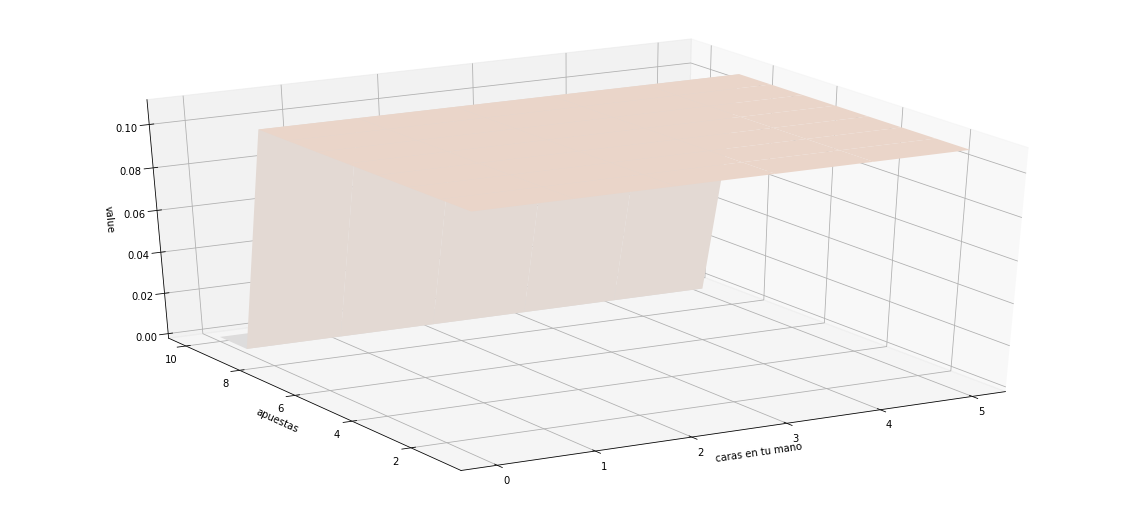

In [892]:
# Calcular la politica optima y el value function
#policy, Q = mc_control(env, 500000, 0.015)
policy, Q = mc_control(env, 500000, 0.015)
V = dict((k, np.max(v)) for k, v in Q.items())
plot_values(V)
#pprint.pprint(Q)

#Deberia hacer que Returns tenga como key SOLO el estado (s,s) y para cada accion, una lista de valores historicos

X (11, 6)
Y (11, 6)
Z (11, 6)
[[1 1 1 1 1 1]
 [1 1 1 1 1 1]
 [1 1 1 1 1 1]
 [1 1 1 1 1 1]
 [1 1 1 1 1 1]
 [1 1 1 1 1 1]
 [1 1 1 1 1 1]
 [1 1 1 1 1 1]
 [1 1 1 1 1 1]
 [0 1 0 0 0 0]
 [1 1 1 1 0 1]]


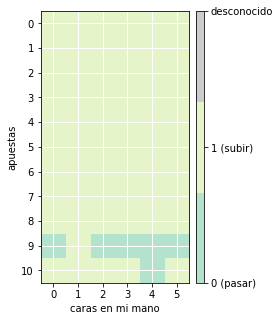

In [893]:
# plotear la politica
plot_policy(policy)
# Para Q y policy use diccionarios y una tupla del otro lado
# TODO: Cambiar la tupla por el valor de la accion que toma, al menos para policy, para Q NO

## SARSA

In [572]:
def update_Q_sarsa(alpha, gamma, Q, state, action, reward, next_state=None, next_action=None):
    # Completar
    
def epsilon_greedy(Q, state, nA, eps):
    # Completar

IndentationError: expected an indented block (<ipython-input-572-8e1d0f36ecc6>, line 4)

In [ ]:
def sarsa(env, num_episodes, alpha, gamma=1.0, epsmin=0.01):
    # Completar
    return Q

In [ ]:
# Calcular la politica optima y el value function
Q_sarsa = sarsa(env, 500000, 0.009)
V = dict((k,np.max(v)) for k, v in Q_sarsa.items())
plot_values(V)

In [ ]:
# plotear la politica
policy_sarsa = dict((k,np.argmax(v)) for k, v in Q_sarsa.items())
plot_policy(policy_sarsa)

## Q-learning

In [ ]:
def update_Q_sarsamax(alpha, gamma, Q, state, action, reward, next_state=None):
    # Completar
    return new_value

In [ ]:
def q_learning(env, num_episodes, alpha, gamma=1.0,epsmin=0.01):
    # Completar
    return Q

In [ ]:
# Calcular la politica optima y el value function
Q_sarsamax = q_learning(env, 500000, 0.01)
V = dict((k,np.max(v)) for k, v in Q_sarsamax.items())
plot_values(V)

In [ ]:
# plotear la politica
policy_sarsamax = dict((k,np.argmax(v)) for k, v in Q_sarsamax.items())
plot_policy(policy_sarsamax)